 # Исследовательский анализ данных о компьютерных играх

**Описание проекта**

Заказчик -  интернет-магазин, который продаёт по всему миру компьютерные игры.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Описание данных**
- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
- *EU_sales* — продажи в Европе (миллионы проданных копий)
- *JP_sales* — продажи в Японии (миллионы проданных копий)
- *Other_sales* — продажи в других странах (миллионы проданных копий)
- *Critic_Score* — оценка критиков (максимум 100)
- *User_Score* — оценка пользователей (максимум 10)
- *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

Данные за 2016 год могут быть неполными.

In [1]:
# Ячейка с импортируемыми библиотеками
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

# Шаг 1. Откроем файл с данными и изучим общую информацию

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Шаг 2. Подготовка данных

In [5]:
# Для удобства сменим регистр названия столбцов на нижний
df.columns = df.columns.str.lower()

In [6]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

<span style="font-size: 18px !important; color:blue">
Необходимо изменить тип данных в столбцах:
    
- year_of_release на int (год - целое число)
    
- user_score на float (оценка - это число)
    
</span>

*Но сначала поработаем с пропусками*

In [7]:
# Посмотрим на количество пропусков в каждом столбце
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
# Количество пропусков в процентном соотношении
df.isna().sum()/df.shape[0]*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

In [9]:
# Дропнем строки без названий игр (0.01%), потому что они бесполезны - непонятно, какую игру исследуем
df = df.dropna(subset=['name']).reset_index(drop=True)
# Строки с пропусками в столбце с годом выхода игры тоже можно удалить, это всего 1.6% данных
df = df.dropna(subset=['year_of_release']).reset_index(drop=True)
# Заменим пропуски в столбце с рейтингом на 'no_rating'
df['rating'] = df['rating'].fillna("no_rating")

In [10]:
# Визуализация колличества пропущенных значений
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (15,3), legend = False, fontsize = 12)
            .set_title('Пропуски' + "\n", fontsize = 18, color = 'SteelBlue')
        );
    except:
        print('Пропусков не осталось, или произошла ошибка в первой части функции.')

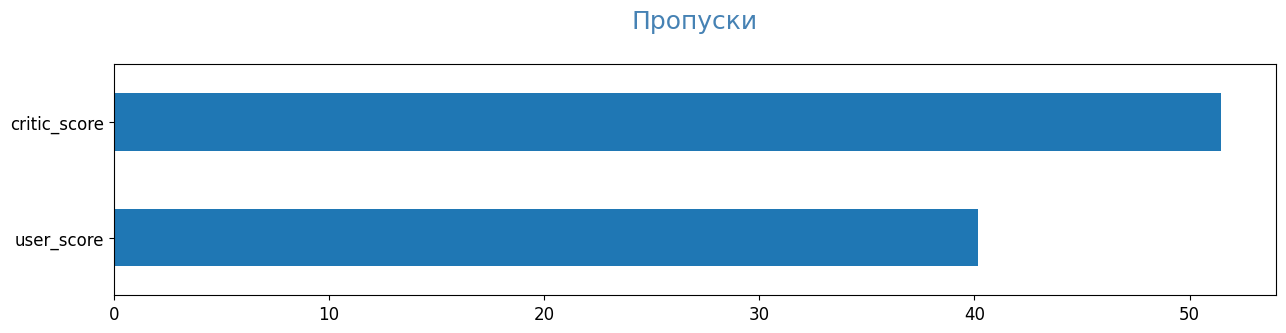

In [11]:
pass_value_barh(df)

<span style="font-size: 18px !important; color:blue">
    В итоге у нас остались пропуски в столбцах с рейтингами и оценками.
    У меня была идея - заполнить их значниями (если такие были) из рейтингов с других платформ, но это будет некорректным, т.к. оценка игр на каждой платформе - индивидуальна ввиду удобства, интерфейса, графики, управления и т.д.
</span>

In [12]:
# В столбце 'user_score' имеется значение 'tbd' (to be discussed, т.е. по сути - неизвестное)
df.query('user_score == "tbd"').sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11653,Bomberman Max 2: Red Advance,GBA,2002.0,Puzzle,0.05,0.02,0.0,0.00,75.0,tbd,E
11522,Man vs. Wild,Wii,2011.0,Action,0.07,0.00,0.0,0.00,NaN,tbd,T
10731,Big League Sports: Summer,Wii,2009.0,Sports,0.09,0.00,0.0,0.01,NaN,tbd,E
10168,Aqua Aqua,PS2,2000.0,Puzzle,0.05,0.04,0.0,0.01,79.0,tbd,E
4440,My Spanish Coach,DS,2007.0,Misc,0.40,0.00,0.0,0.03,73.0,tbd,E
9207,Tak 2: The Staff of Dreams,XB,2004.0,Platform,0.10,0.03,0.0,0.00,73.0,tbd,E
9624,Dance Paradise,X360,2010.0,Misc,0.10,0.01,0.0,0.01,59.0,tbd,T
13157,Cabela's African Safari,PSP,2006.0,Sports,0.04,0.00,0.0,0.00,NaN,tbd,T
15955,Blitzkrieg 2 Anthology,PC,2008.0,Strategy,0.00,0.01,0.0,0.00,NaN,tbd,no_rating
11701,Picture Perfect Hair Salon,DS,2009.0,Simulation,0.07,0.00,0.0,0.01,NaN,tbd,E


In [13]:
# Судя по всему, эта оценка зависит от продаж, т.е. оценка будет тогда, когда игру "попробуют" во всём мире
# Заменим 'tbd' на NaN-значения
df = df.replace({'tbd':np.NaN})

In [14]:
# Заменим тип данных в столбцах 'year_of_release' и 'user_score'
df['year_of_release'] = df['year_of_release'].astype(int)
df['user_score'] = df['user_score'].astype(float)

In [15]:
# Проверка
df.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

In [16]:
# Проверка
df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15424,My Hero: Doctor,DS,2009,Action,0.02,0.00,0.00,0.00,NaN,NaN,E10+
4739,18 Wheeler: American Pro Trucker,PS2,2001,Racing,0.20,0.15,0.00,0.05,61.0,5.7,E
2104,Romancing SaGa,SNES,1992,Role-Playing,0.00,0.00,0.97,0.00,NaN,NaN,no_rating
6815,Dark Cavern,2600,1981,Shooter,0.22,0.01,0.00,0.00,NaN,NaN,no_rating
9904,Samurai Warriors 4-II,PS3,2015,Action,0.00,0.00,0.11,0.00,NaN,NaN,T


In [17]:
# Добавляем столбец с суммарными продажами во всех регионах
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']
df = df[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
         'jp_sales', 'other_sales', 'sum_sales', 'critic_score', 'user_score', 'rating']]
df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,sum_sales,critic_score,user_score,rating
2831,The Sims 2: Castaway,DS,2007,Simulation,0.62,0.04,0.00,0.06,0.66,66.0,4.0,E
12799,Virtua Striker 2002,GC,2002,Sports,0.01,0.00,0.03,0.00,0.04,58.0,6.0,E
984,Golden Sun,GBA,2001,Role-Playing,0.93,0.38,0.40,0.06,1.71,91.0,9.3,E
10817,Green Lantern: Rise of the Manhunters,Wii,2011,Action,0.05,0.03,0.00,0.01,0.08,46.0,NaN,E10+
15005,Commandos: Strike Force,XB,2006,Shooter,0.02,0.00,0.00,0.00,0.02,62.0,NaN,T


In [18]:
# Проверка на дубликаты
df.duplicated().sum()

0

# Шаг 3. Исследовательский анализ данных

## 3.1 Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?

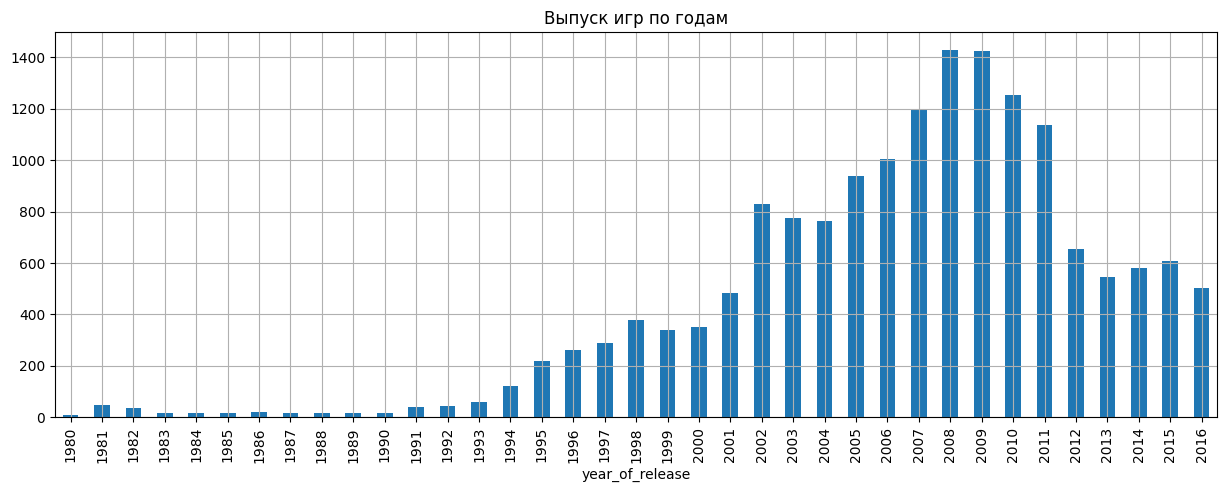

In [19]:
                                    # График объёма выпуска игр по годам
(
df
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind='bar', grid=True, legend=False, figsize=(15,5), title='Выпуск игр по годам')
);

<span style="font-size: 18px !important; color:blue">
    "Пик" продаж приходится на 2008-2009 гг. После этого начинается "спад". В этот период появляются и развиваются смартфоны, которые во многих направлениях "забирают хлеб" у остальных устройств. Этот фактор также нужно учитывать при выборе "актуального" периода, т.к. сегодня смартфоны есть у всех, и не по одному.
</span>

Полагаю, первый подъём в 1994 году, да и следующий в 2001 можно связать с выходом консолей Sony PlayStation первого и второго поколений. По личному опыту знаю - эти приставки вывели "игроманию" на новый уровень, задали планку остальным платформам. Все мы мечтали о "Соньке", но как правило довольствовались "Сегой" у сына маминой подруги 😆
    
В 2001 году ещё и Microsoft подарил миру свои XBox.
  
Следующий подъём в 2005-2006 гг. связываю с выходом PlayStation 3 и XBox 360.

## 3.2 Как менялись продажи по платформам.

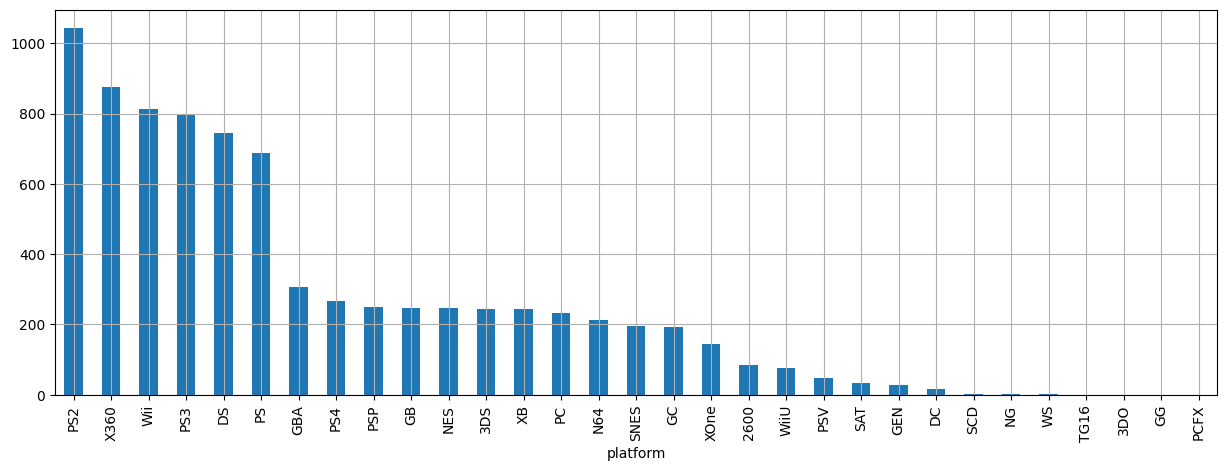

In [20]:
# Визуализация общего количества продаж по платформам
(
df
    .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values(by='sum_sales', ascending=False)
    .plot(kind='bar', grid=True, legend=False, figsize=(15,5))
);

<span style="font-size: 18px !important; color:blue">
    Для удобства отображения разделим "фаворитов" <b>по наибольшим суммарным продажам</b> на две группы. Они хорошо видны на графике выше. Первая группа (ТОП-6) от "S2" до "PS", вторая группа - от "GBA" до "PC"
</span>

In [21]:
# Топ платформ:
top_platforms1 = df.pivot_table(index='platform', values='sum_sales', aggfunc='sum') \
.sort_values(by='sum_sales', ascending=False).index.values[:6]
top_platforms2 = df.pivot_table(index='platform', values='sum_sales', aggfunc='sum') \
.sort_values(by='sum_sales', ascending=False).index.values[6:14]
print('Первая группа фаворитов:', top_platforms1)
print('Вторая группа фаворитов:', top_platforms2)

Первая группа фаворитов: ['PS2' 'X360' 'Wii' 'PS3' 'DS' 'PS']
Вторая группа фаворитов: ['GBA' 'PS4' 'PSP' 'GB' 'NES' '3DS' 'XB' 'PC']


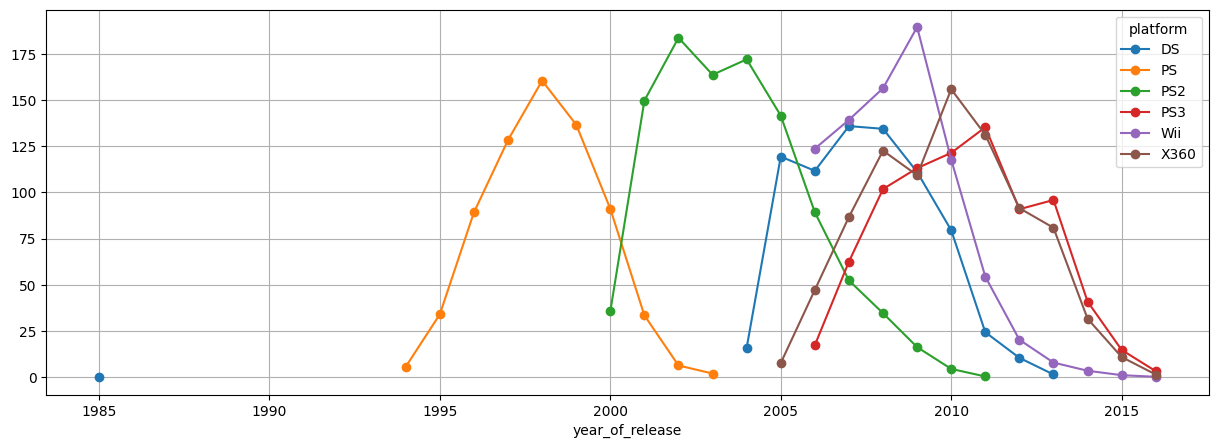

In [22]:
# Для просмотра сумм продаж по годам создадим сводную таблицу с топ-платформами
top_platforms_list1 = df[df.platform.isin(top_platforms1)]
top_platforms_list1.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum') \
.plot(figsize=(15,5), grid=True, style='o-');

<span style="font-size: 18px !important; color:blue">
  На 1985 году видим странность - платформа DS. Посмотрим все записи с этой платформой в 1985 году.
</span>

In [23]:
df.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,sum_sales,critic_score,user_score,rating
15704,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,0.02,NaN,NaN,no_rating


<span style="font-size: 18px !important; color:blue">
    На официальном сайте <a href="https://www.nintendo.com/about/">www.nintendo.com/about/</a> обозначена дата появления платформы DS (Nintendo Dual Screen) - это 2004 год. В данных - ошибка. Исправить её не получится, так как информацию по этой игре я не нашёл, поэтому удаляем строку с этой записью.
</span>

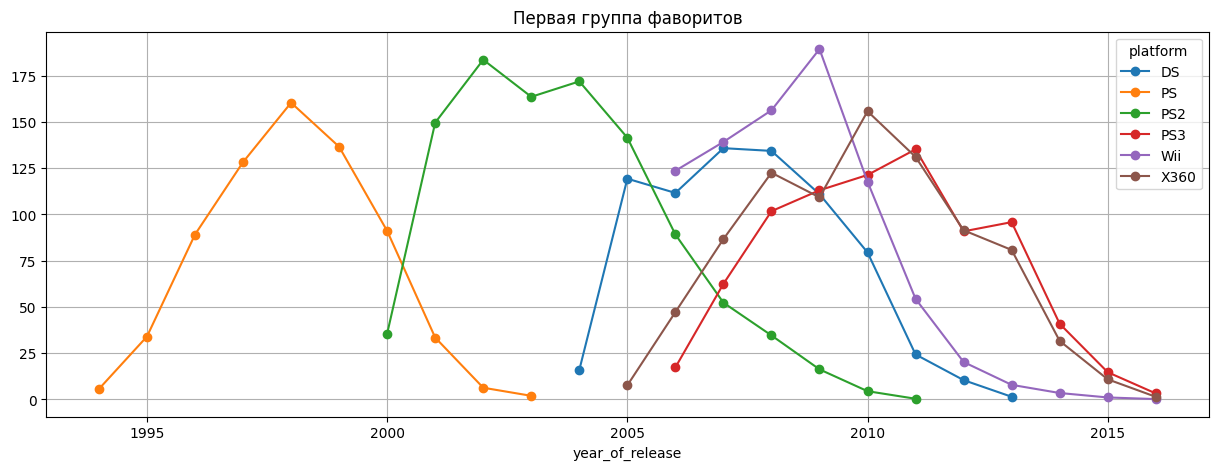

In [24]:
# Удаляем строку 15704
df = df.drop(index=[15704]);
# Смотрим заново суммы продаж по годам с первой группой "фаворитов"
top_platforms_list1 = df[df.platform.isin(top_platforms1)]
top_platforms_list1.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum') \
.plot(figsize=(15,5), grid=True, style='o-', title='Первая группа фаворитов');

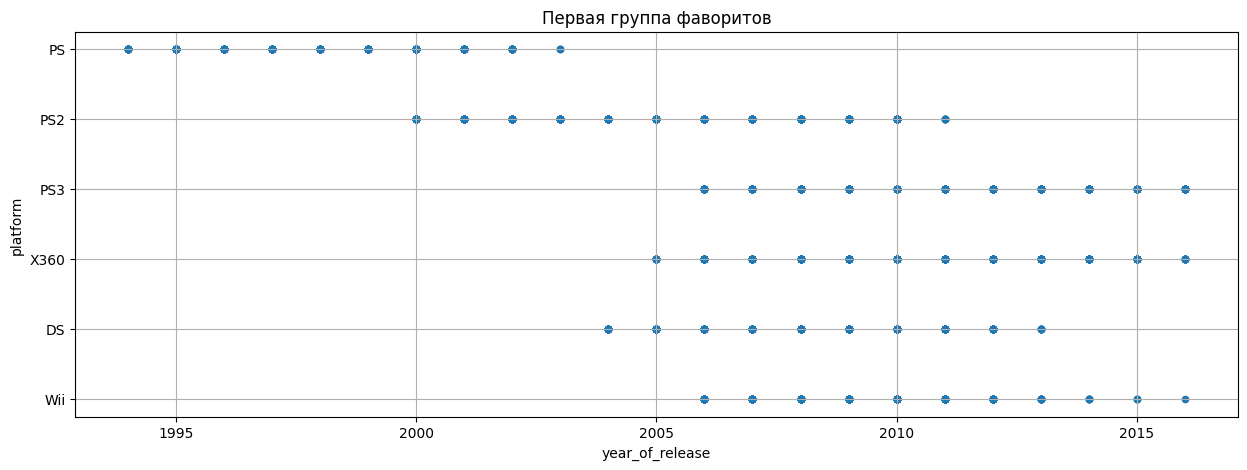

In [25]:
# Первая група "фаворитов"
top_platforms_list1.plot(kind='scatter', x='year_of_release', y='platform',
                         grid=True, figsize=(15,5), title='Первая группа фаворитов');

<span style="font-size: 18px !important; color:blue">
    До 2016 года "дотянули" <b> "PS3", "X360" и "Wii"</b>.
</span>

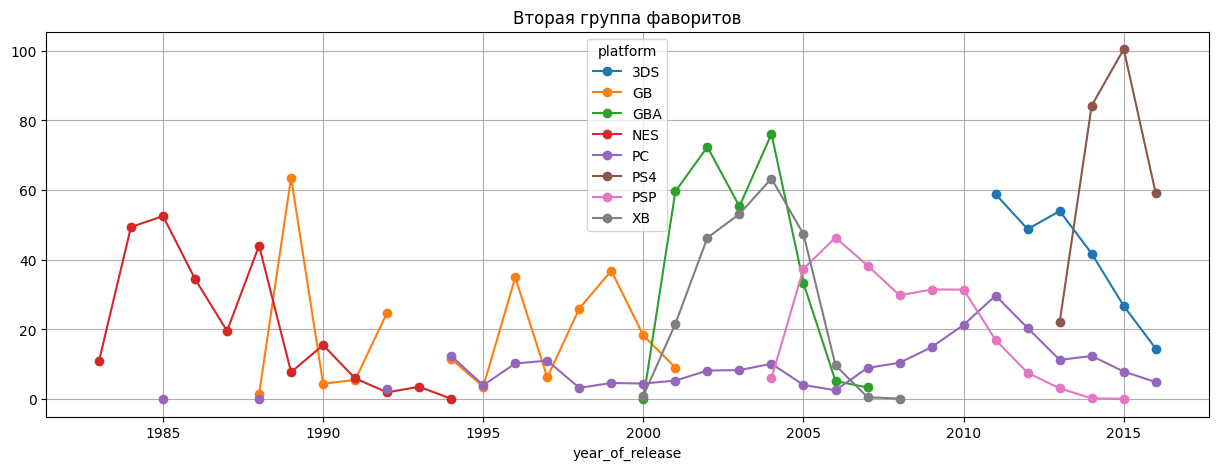

In [26]:
# Вторая група "фаворитов"
top_platforms_list2 = df[df.platform.isin(top_platforms2)]
top_platforms_list2.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum') \
.plot(figsize=(15,5), grid=True, style='o-', title='Вторая группа фаворитов');

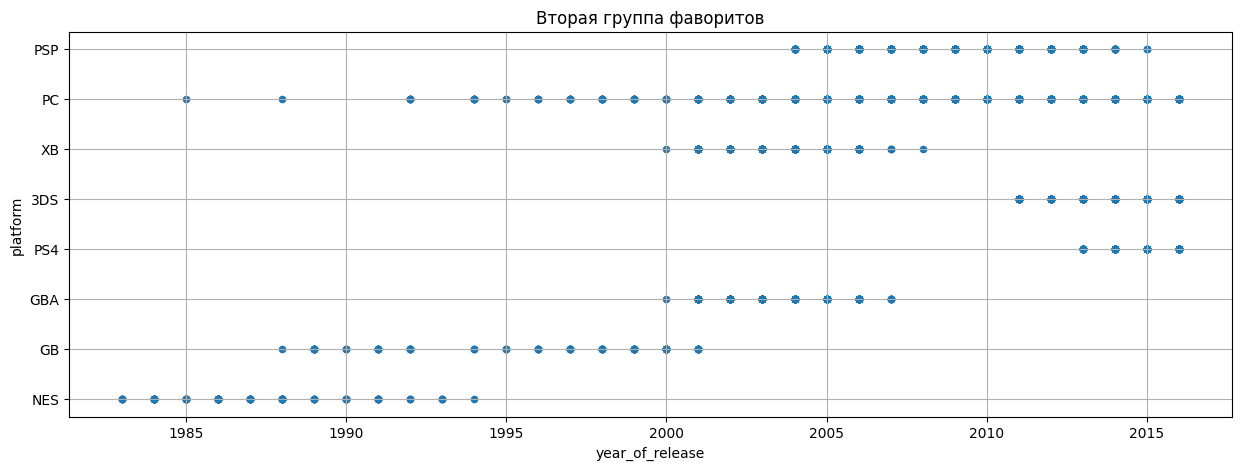

In [27]:
# Вторая група "фаворитов"
top_platforms_list2.plot(kind='scatter', x='year_of_release', y='platform', grid=True,
                         figsize=(15,5), title='Вторая группа фаворитов');

<span style="font-size: 18px !important; color:blue">
    До 2016 года "дотянули" <b>"PS4", "3DS" </b> и "PC". Но, "PC" (персональные компьютеры), как ни крути - будет присутствовать на любом промежутке времени.
</span>

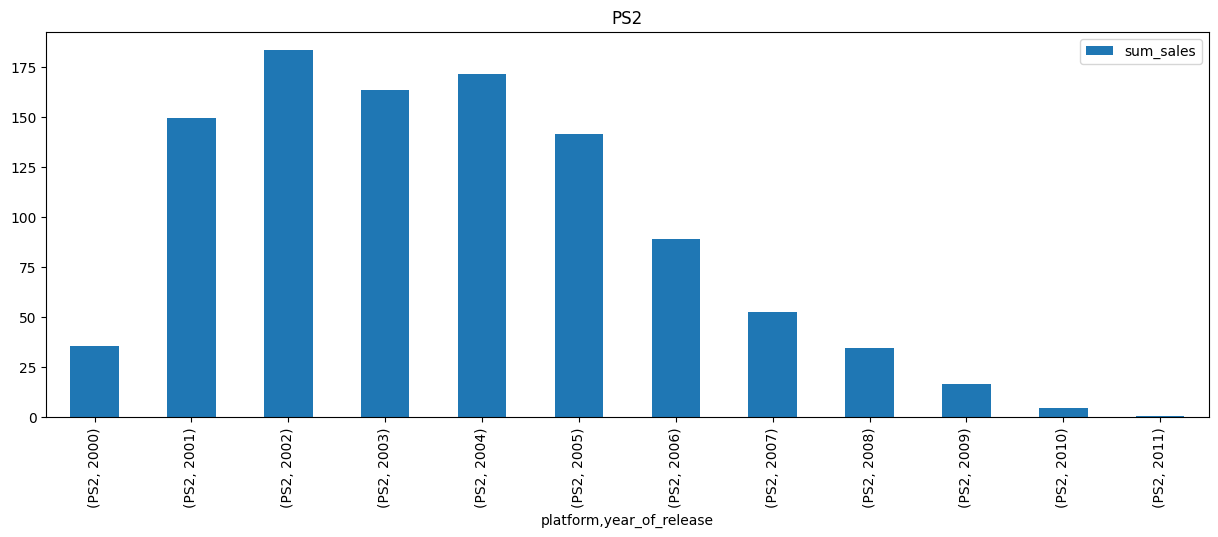

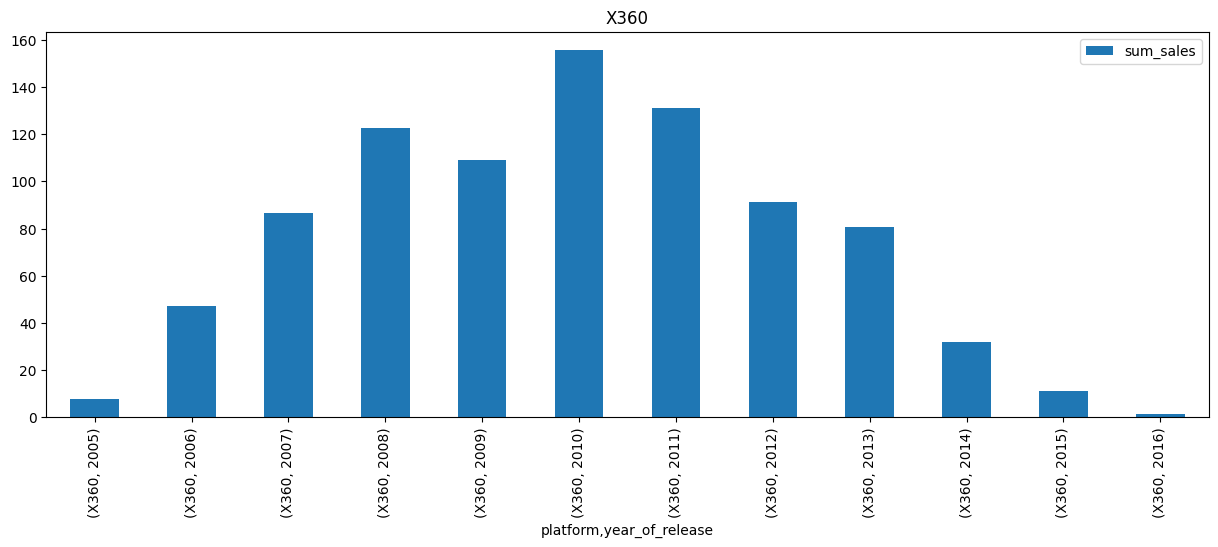

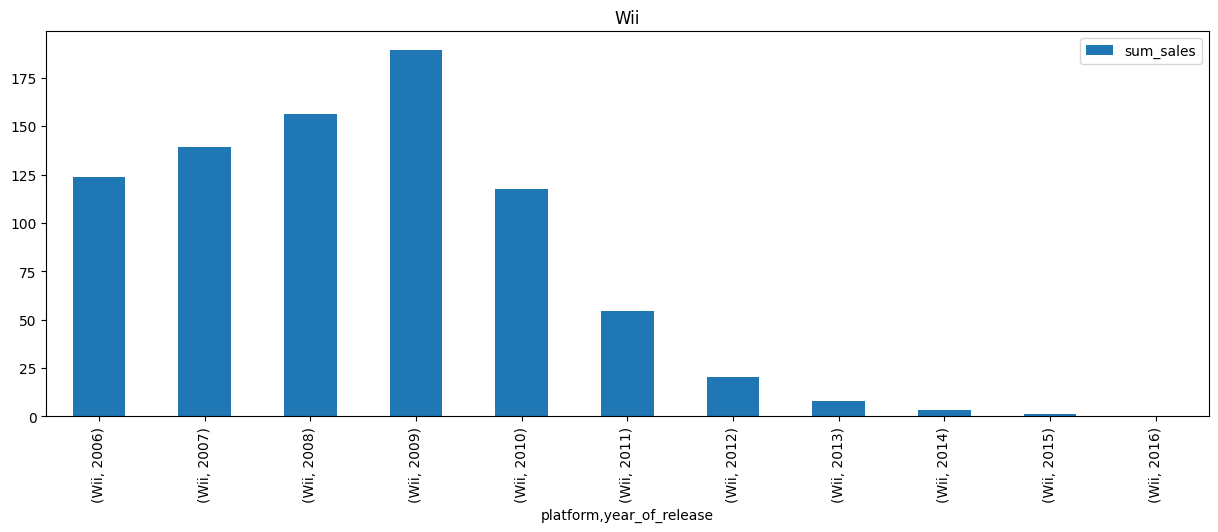

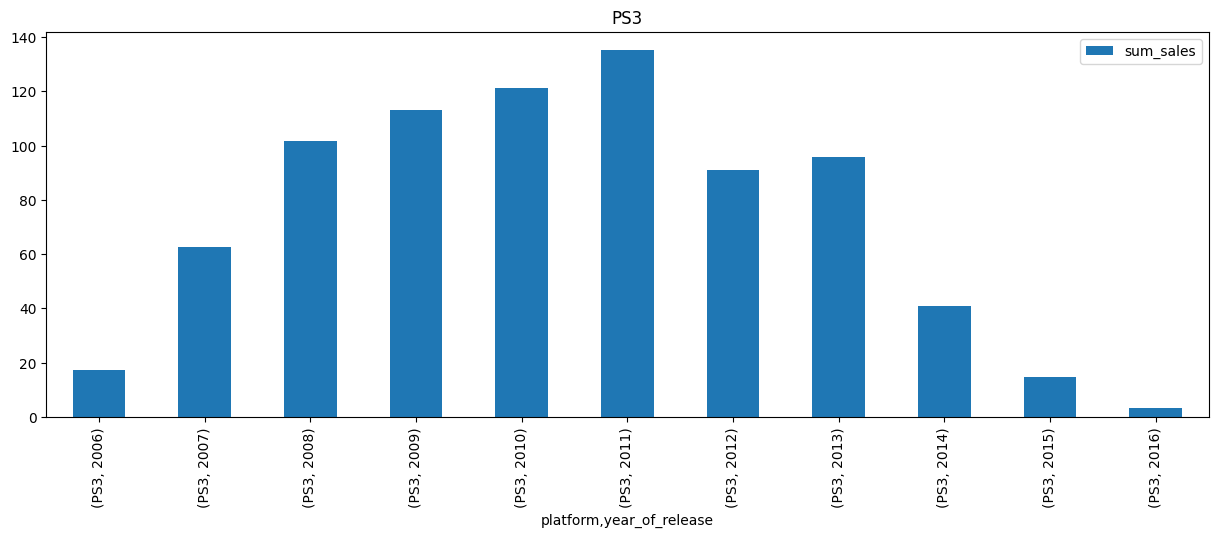

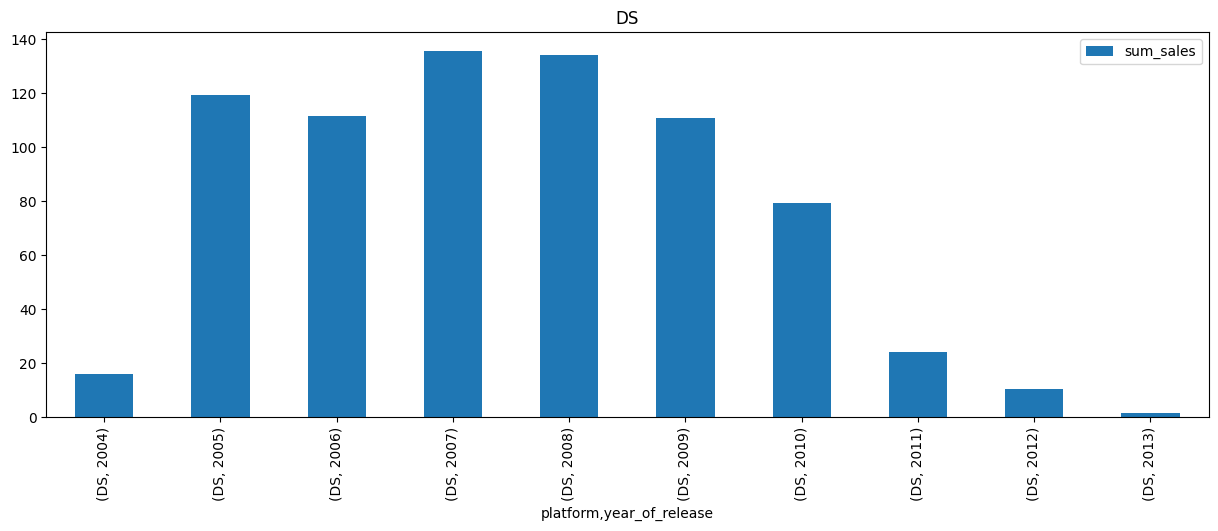

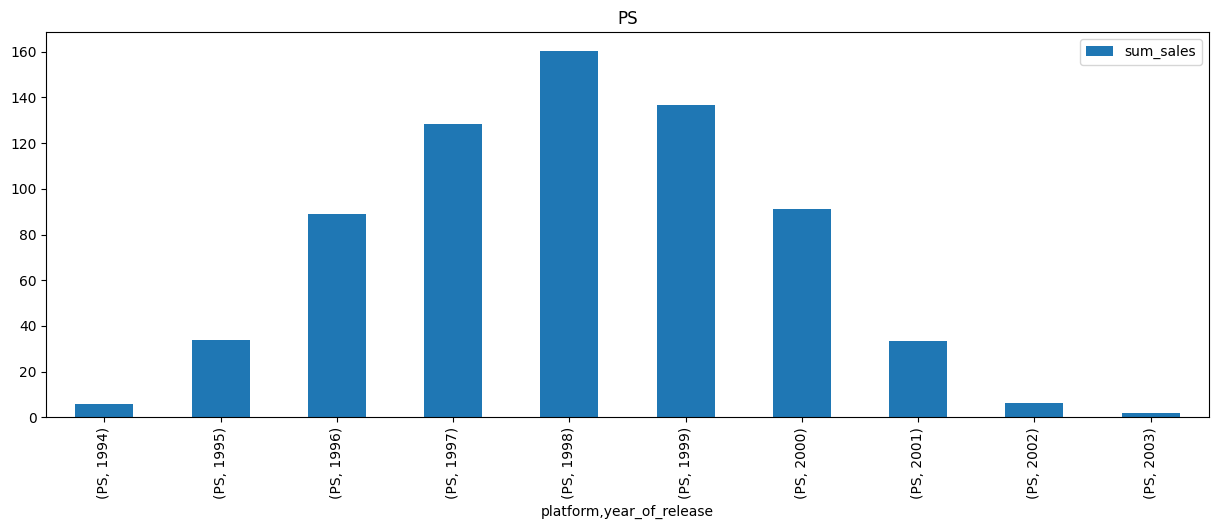

In [28]:
# Рассмотрим первую шестёрку по годам
for platform in top_platforms1:
    pd.pivot_table(df.query('platform == @platform'), index=['platform','year_of_release'], values='sum_sales',
                   aggfunc='sum').plot(kind='bar', figsize=(15,5), title=platform)

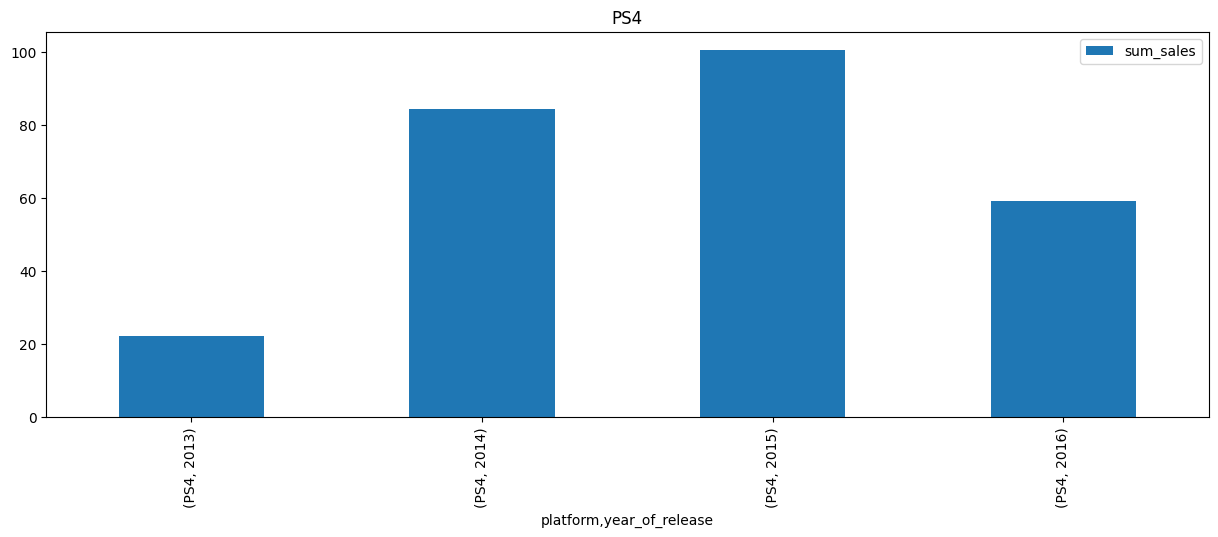

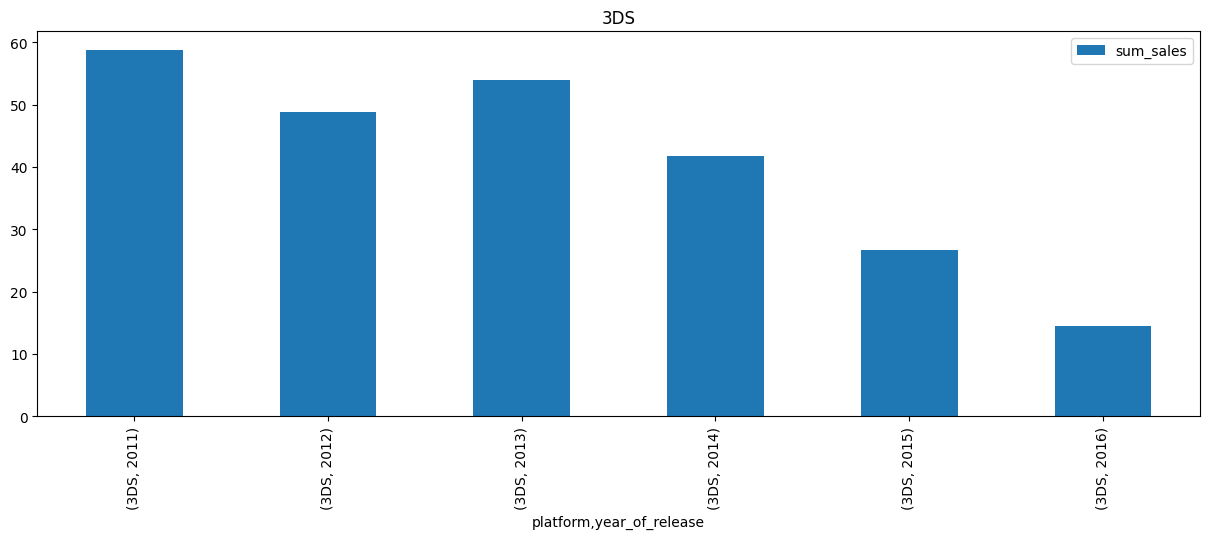

In [29]:
# Также рассмотрим "дотянувших" до 2016 г. лидеров из второй группы
pd.pivot_table(df.query('platform == "PS4"'), index=['platform','year_of_release'], values='sum_sales',
               aggfunc='sum').plot(kind='bar', figsize=(15,5), title='PS4');
pd.pivot_table(df.query('platform == "3DS"'), index=['platform','year_of_release'], values='sum_sales',
               aggfunc='sum').plot(kind='bar', figsize=(15,5), title='3DS');

<span style="font-size: 18px !important; color:blue">
   Для платформ, которые пользуются популярностью, актуальный срок использования находится в диапазоне 8-12 лет. Для примера проследим, как менялись поколения для приствок PlayStation:

    
- PS 1994-2003
- PS2 2000-2011
- PS3 2006-2016
- PS4 2013-по сегодняшний день
    
Получается каждые 5-7 лет компания Sony выпускает новую платформу с лучшими техническими параметрами, при этом игры на предыдущей платформе продолжают существовать на рынке не менее 3х лет.
</span>

## 3.3 Актуальный период.
<span style="font-size: 18px !important; color:blue">
Итак. Актуальным периодом считаю 5 лет (с 2012 по 2016 гг.)
Платформа PS4 недавно появилась на рынке, и пик продаж игр для неё выпадет как раз на 2017 год. Если считать, что на создание игры уходит 2-4 года, то релиз игр, разработка которых ведется с 2013 года тоже выпадает на 2017 год. Продаваться игры будут также несколько лет.
</span>

## 3.4 Выбор потенциально прибыльных платформ.

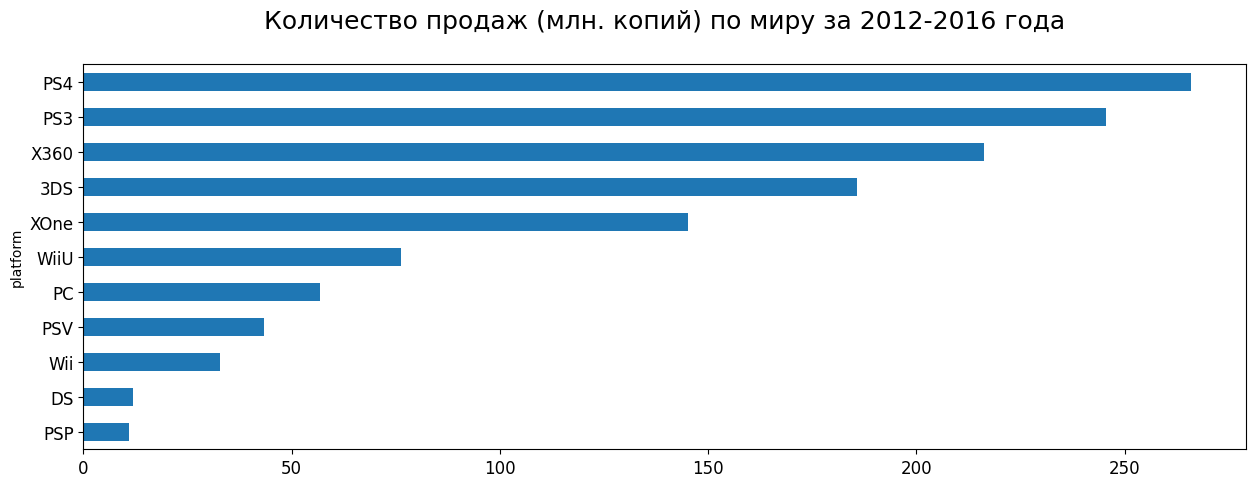

In [30]:
# Создаём новый датафрейм на основе среза данных за период 2012 - 2016 год
df_5 = df.query('year_of_release >= 2012')
# Визуализируем общее число продаж по платформам за выбранный период
(
df_5
    .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values('sum_sales', ascending=True)
    .plot(kind = 'barh', figsize = (15,5), legend = False, fontsize = 12)
    .set_title('Количество продаж (млн. копий) по миру за 2012-2016 года' + "\n", fontsize = 18)
);

In [31]:
# 5 потенциально прибыльных платформ:
df_5.pivot_table(index='platform', values='sum_sales',
                  aggfunc='sum').sort_values('sum_sales', ascending=False).head(5)

,sum_sales
platform,
PS4,265.79
PS3,245.53
X360,216.14
3DS,185.74
XOne,145.05


<span style="font-size: 18px !important; color:blue">
Посмотрим продажи у лидеров по годам (растут или падают?). Период возьмём до 2015 года включительно, т.к. за 2016 год данные - не полные.
</span>

In [32]:
# ТОП-5 платформ по продажам
leaders = ['PS4', 'XOne', 'PS3', 'X360', '3DS']
# Сводная по срезу 2012 - 2015 гг. с количеством продаж по годам
df_5.query('year_of_release <= 2015 and platform == @leaders').pivot_table(index=['platform', \
'year_of_release'], values='sum_sales', aggfunc='sum')

sum_sales
platform year_of_release           
3DS      2012                 48.77
         2013                 53.97
         2014                 41.75
         2015                 26.75
PS3      2012                 90.87
         2013                 95.85
         2014                 40.88
         2015                 14.70
PS4      2013                 22.12
         2014                 84.22
         2015                100.44
X360     2012                 91.45
         2013                 80.82
         2014                 31.61
         2015                 10.86
XOne     2013                 17.21
         2014                 49.26
         2015                 54.67

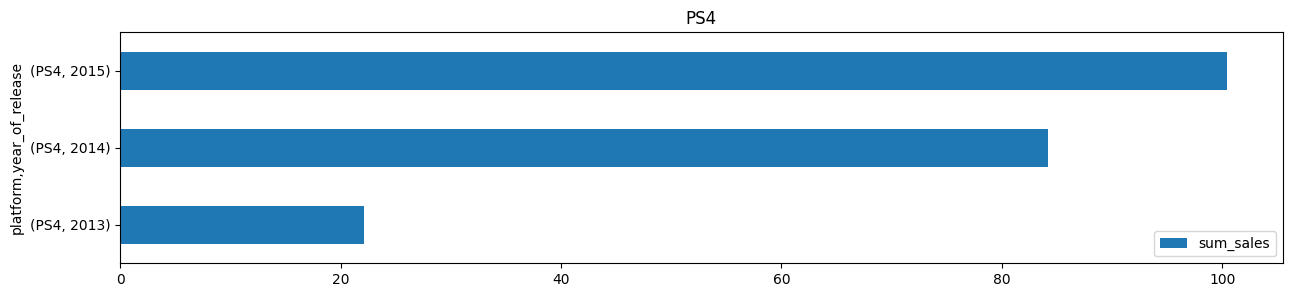

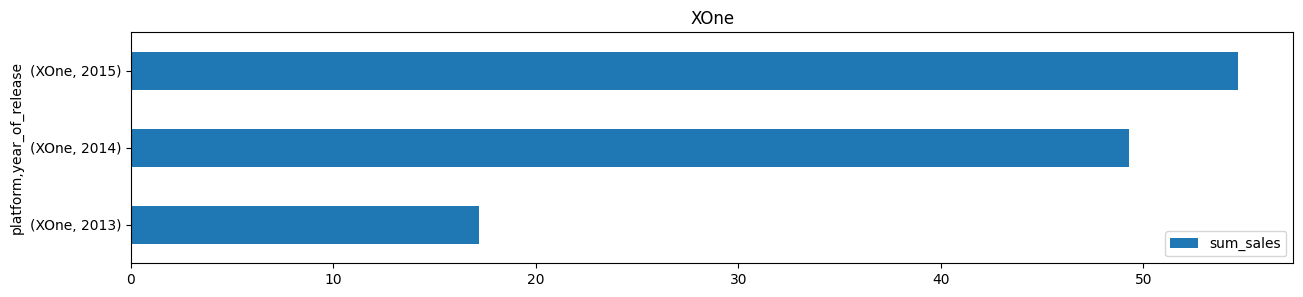

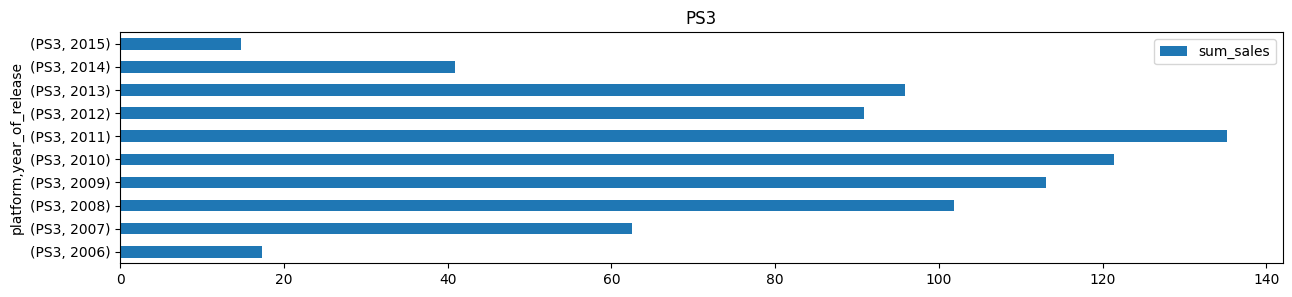

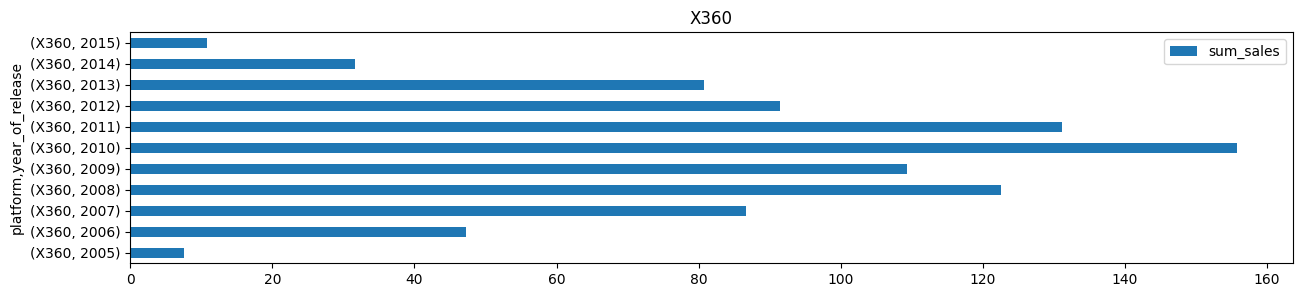

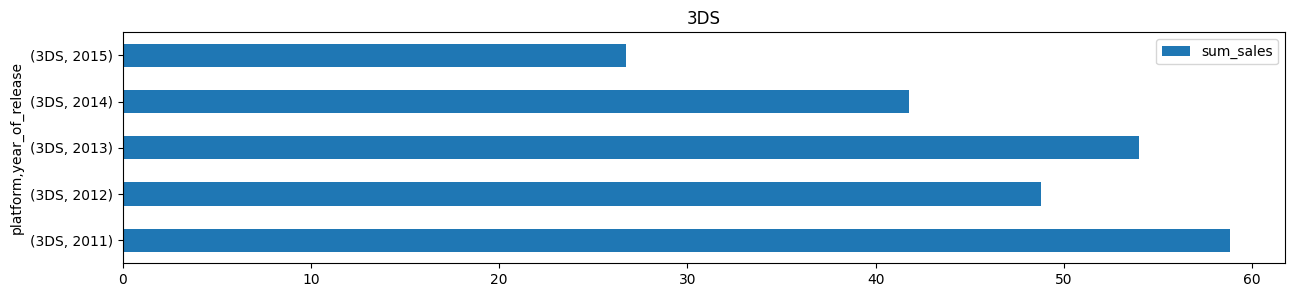

In [33]:
for platform in leaders:
    pd.pivot_table(df.query('platform == @platform and year_of_release < 2016'),
                   index=['platform','year_of_release'], values='sum_sales',
                   aggfunc='sum').plot(kind='barh', figsize=(15,3), title=platform)

<span style="font-size: 18px !important; color:blue">
    Как видно из таблицы и графиков - у платформ PS4 и XOne показатели пошли в гору к 2015 году. Считаю это два основных претендента на звание потенциально прибыльной платформы, потому как они ещё и самые молодые.
    Также не стоит "забрасывать" старших братьев этих платформ. В итоге выделю пятёрку потенциально прибыльных платформ: <b>PS4, XOne, 3DS, PS3 и X360</b>
</span>

## 3.5 Диаграмма размаха по глобальным продажам игр в разбивке по платформам.

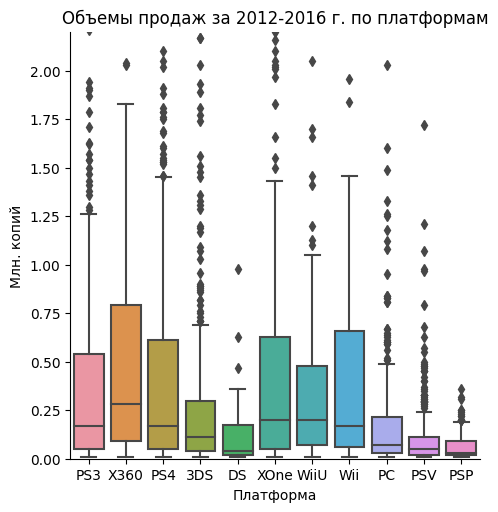

In [34]:
sns.catplot(x="platform", y='sum_sales', kind="box", data=df_5)
plt.title('Объемы продаж за 2012-2016 г. по платформам')
plt.xlabel('Платформа')
plt.ylabel('Млн. копий')
plt.ylim(0, 2.2);

<span style="font-size: 18px !important; color:blue">
    На графике видно, что в своём большинстве продажи не превышают одного миллиона копий, но в районе выбросов и за гранью графиков видно игры - лидеры продаж, которые дают много прибыли
</span>

## 3.6 Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков. Диаграмма рассеяния и корреляция между отзывами и продажами.

<ipython-input-35-0084b304ca1e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(ps4.corr())


,sum_sales,critic_score,user_score
sum_sales,1.000000,0.405887,-0.031261
critic_score,0.405887,1.000000,0.557654
user_score,-0.031261,0.557654,1.000000


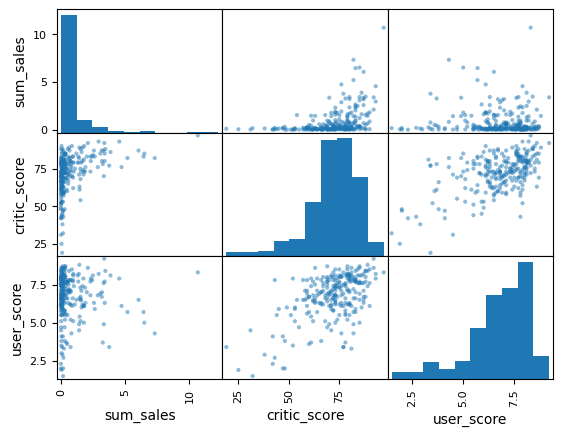

In [35]:
# Рассмотрим платформу PS4
ps4 = df_5[['platform', 'sum_sales', 'critic_score', 'user_score']].query('platform == "PS4"')
display(ps4.corr())
pd.plotting.scatter_matrix(ps4);

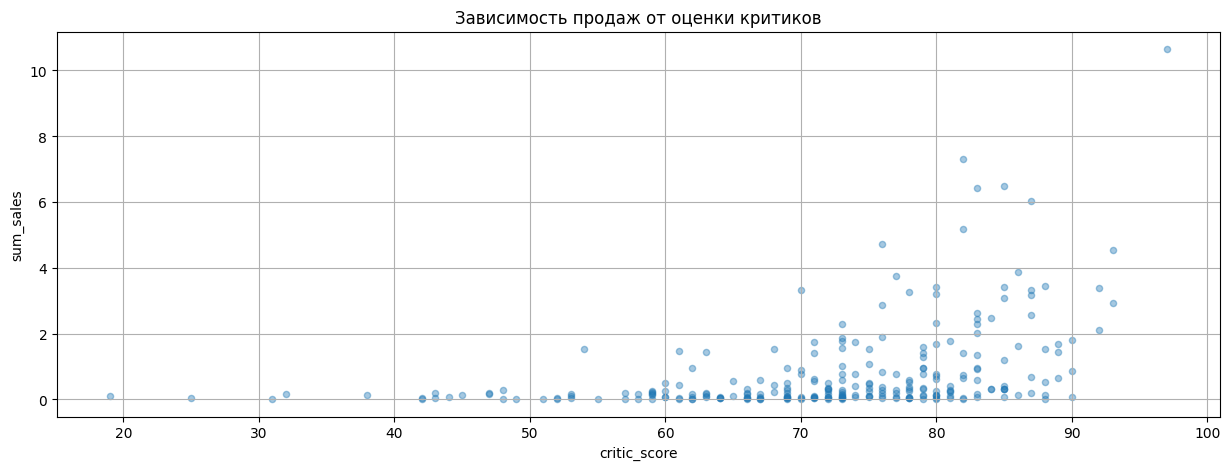

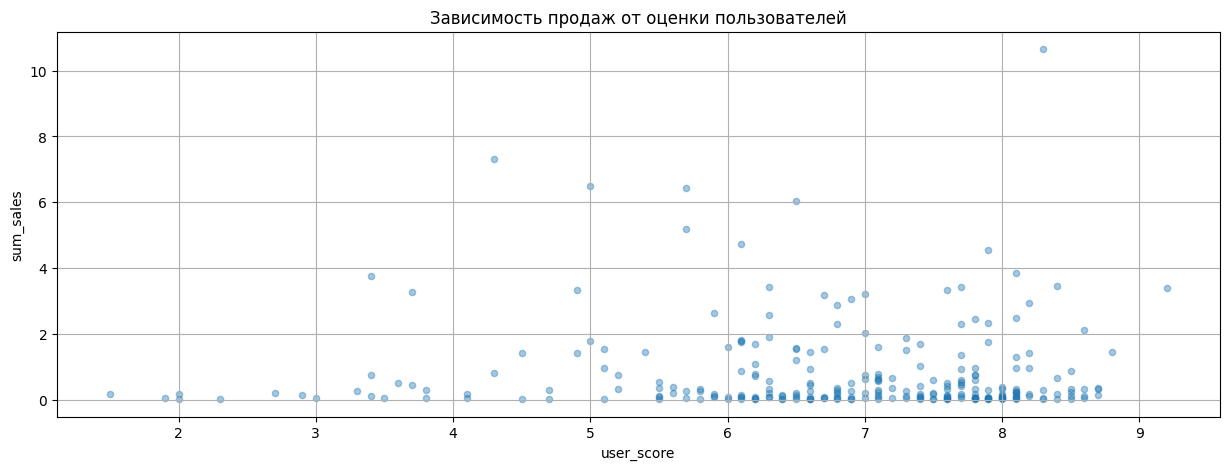

In [36]:
ps4.plot(title='Зависимость продаж от оценки критиков',
         x='critic_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));
ps4.plot(title='Зависимость продаж от оценки пользователей',
         x='user_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));

<span style="font-size: 18px !important; color:blue">Игры с оценкой критиков 70+ покупают охотнее.
В рассматриваемых данных корреляция имеется между оценкой критиков и суммами продаж, но, как видно на графике, она не сильная. Между оценкой пользователей и суммами продаж корреляции нет.
Также видна зависимость оценки пользователей от оценки критиков.</span>

## 3.7 Соотнесём выводы с продажами игр на других платформах.

<ipython-input-37-3ee09b016bbe>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(x360.corr())


,sum_sales,critic_score,user_score
sum_sales,1.000000,0.360260,0.006563
critic_score,0.360260,1.000000,0.557352
user_score,0.006563,0.557352,1.000000


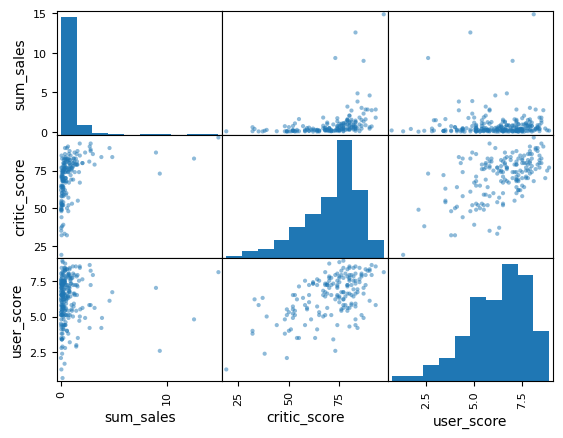

In [37]:
# Рассмотрим платформу X360
x360 = df_5[['platform', 'sum_sales', 'critic_score', 'user_score']].query('platform == "X360"')
display(x360.corr())
pd.plotting.scatter_matrix(x360);

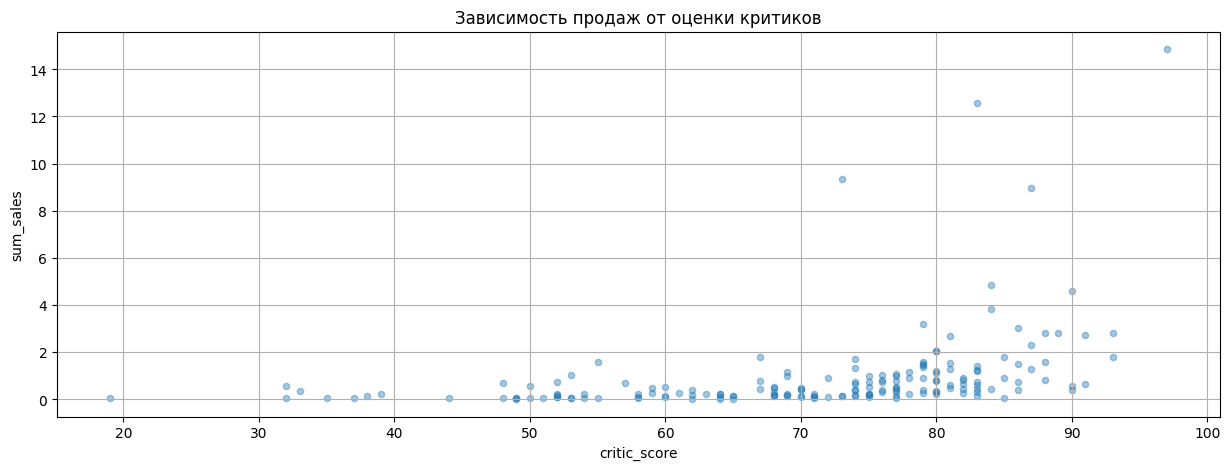

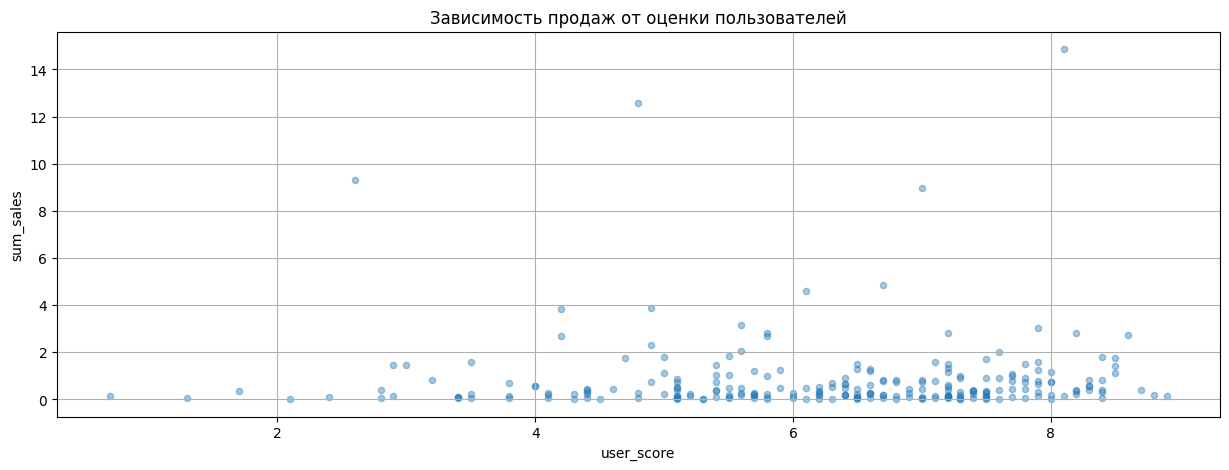

In [38]:
x360.plot(title='Зависимость продаж от оценки критиков',
         x='critic_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));
x360.plot(title='Зависимость продаж от оценки пользователей',
         x='user_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));

<span style="font-size: 18px !important; color:blue">Картина примерно та же. Игры с оценкой критиков 70+ покупают охотнее.
Имеется зависимость между оценкой критиков и суммами продаж, но не сильная. Между оценкой пользователей и суммами продаж корреляции нет.
Также видна зависимость оценки пользователей от оценки критиков.</span>

<ipython-input-39-a20d9f1b270f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(pc.corr())


,sum_sales,critic_score,user_score
sum_sales,1.000000,0.237523,-0.123060
critic_score,0.237523,1.000000,0.432587
user_score,-0.123060,0.432587,1.000000


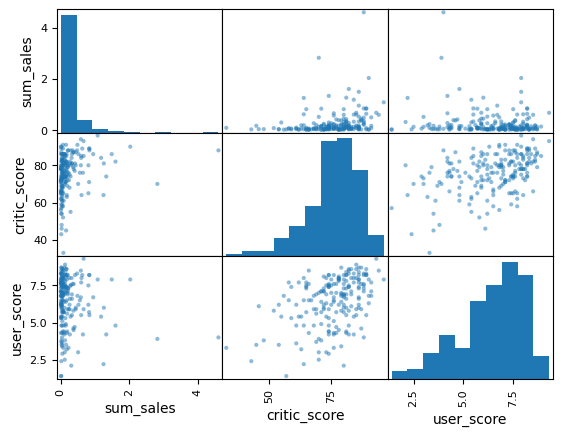

In [39]:
# Ради интереса рассмотрим платформу PC
pc = df_5[['platform', 'sum_sales', 'critic_score', 'user_score']].query('platform == "PC"')
display(pc.corr())
pd.plotting.scatter_matrix(pc);

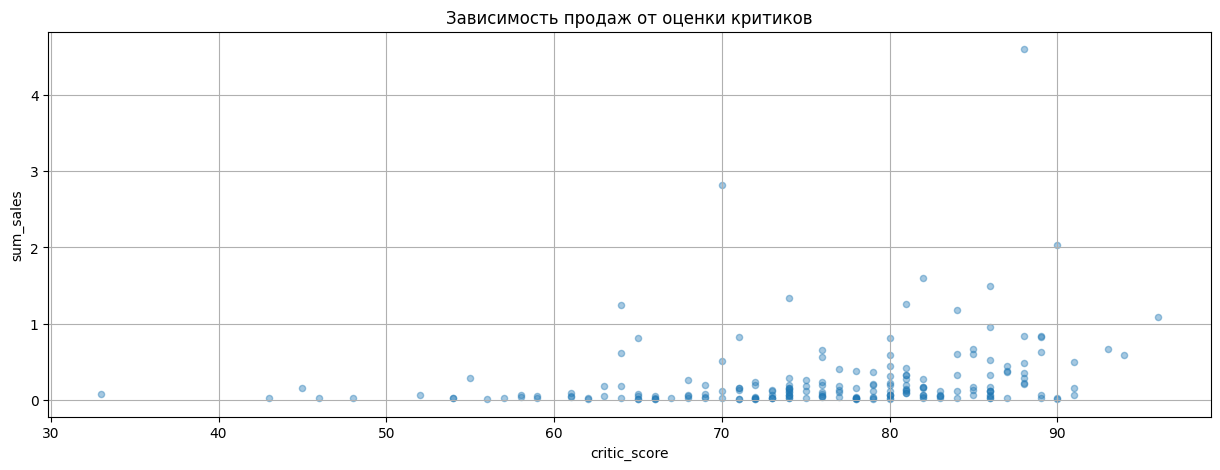

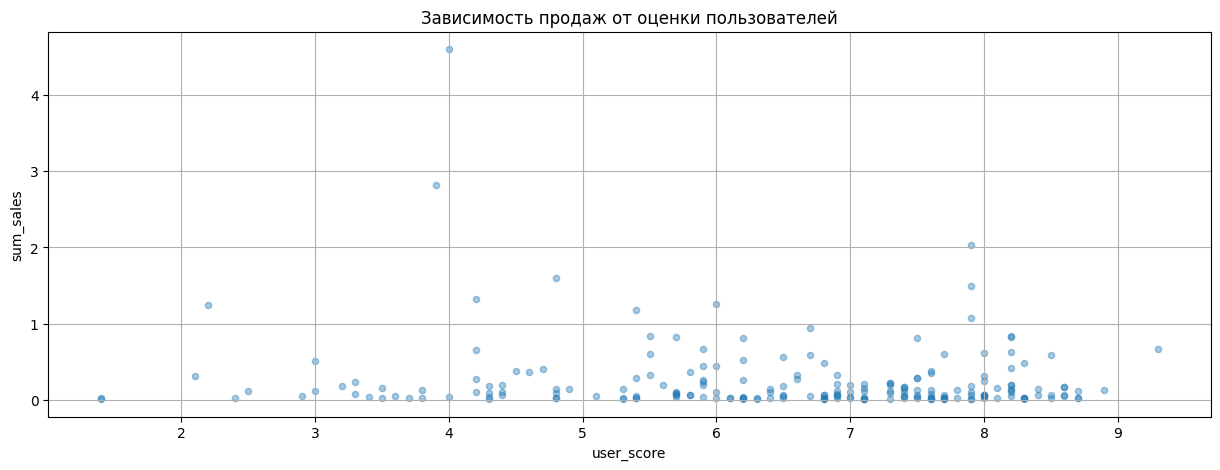

In [40]:
pc.plot(title='Зависимость продаж от оценки критиков',
         x='critic_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));
pc.plot(title='Зависимость продаж от оценки пользователей',
         x='user_score', y='sum_sales', kind='scatter', grid=True, alpha=0.4, figsize=(15,5));

<span style="font-size: 18px !important; color:blue">В общем и целом, наблюдается одна и та же тенденция. Игры с оценкой критиков 70+ покупают охотнее. Но напрямую количество продаж не зависит от оценки, которую дали критики или пользователи.
Также видна зависимость оценки пользователей от оценки критиков.</span>

## 3.8 Общее распределение игр по жанрам.

<span style="font-size: 18px !important; color:blue">Вначале для анализа распределения по жанрам мы брали весь датафрейм (1985-2016 гг.), но как мне кажется, правильнее рассматривать выбраный нами ранее "актуальный" период (2012-2016 гг.), т.к. игровая индустрия стремительно развивается, требования и вкусы конечного пользователя также меняются из года в год. И правильнее видеть картину исходя из современных тенденций. Поэтому рассмотрим общее распределение игр по жанрам за 2012-2016 гг.</span>

In [41]:
# Количество записей по жанрам
display(df_5.groupby('genre').size().sort_values(ascending=False).to_frame().T)

genre,Action,Role-Playing,Adventure,Sports,Shooter,Misc,Racing,Fighting,Platform,Simulation,Strategy,Puzzle
0,1031,370,302,268,235,192,115,109,85,80,71,28


<span style="font-size: 18px !important; color:blue">Пятёрка лидеров среди жанров <b>выпускаемых</b> игр:
</span>
- Action
- Role-Playing
- Adventure
- Sports
- Shooter

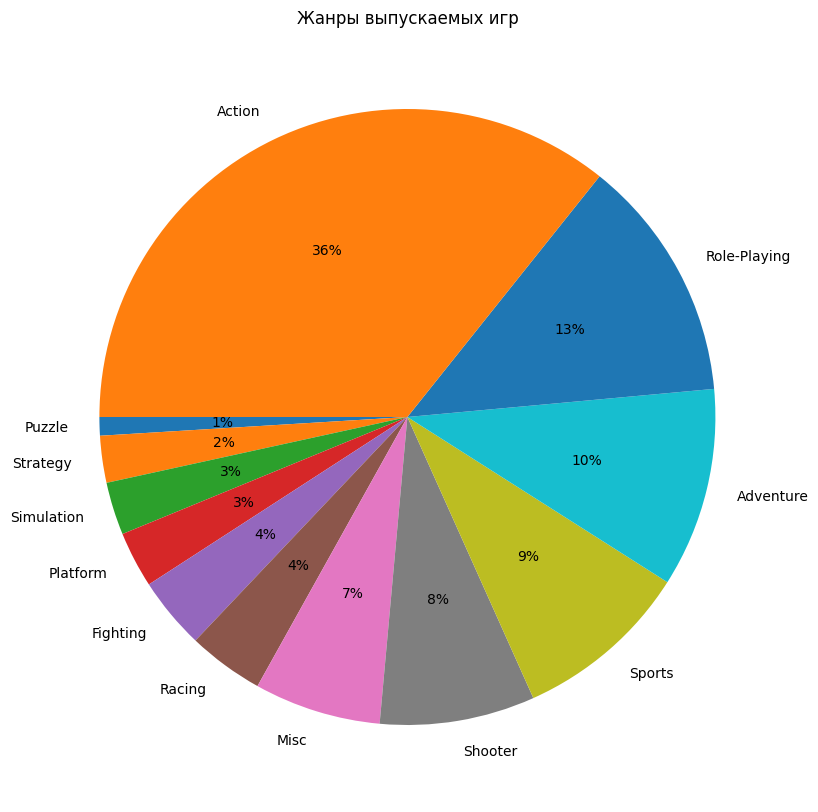

In [42]:
df_5.groupby('genre').size().sort_values(ascending=True).plot(kind='pie', ylabel='', \
autopct='%1.0f%%', title='Жанры выпускаемых игр', legend=False, startangle=180, figsize=(10,10));

**Чтобы найти жанр, где игры стабильно приносят высокий доход - рассмотрим медианные продажи.**

genre,Shooter,Sports,Platform,Role-Playing,Fighting,Misc,Racing,Action,Simulation,Strategy,Puzzle,Adventure
sum_sales,0.38,0.215,0.19,0.135,0.13,0.12,0.12,0.11,0.11,0.07,0.04,0.03


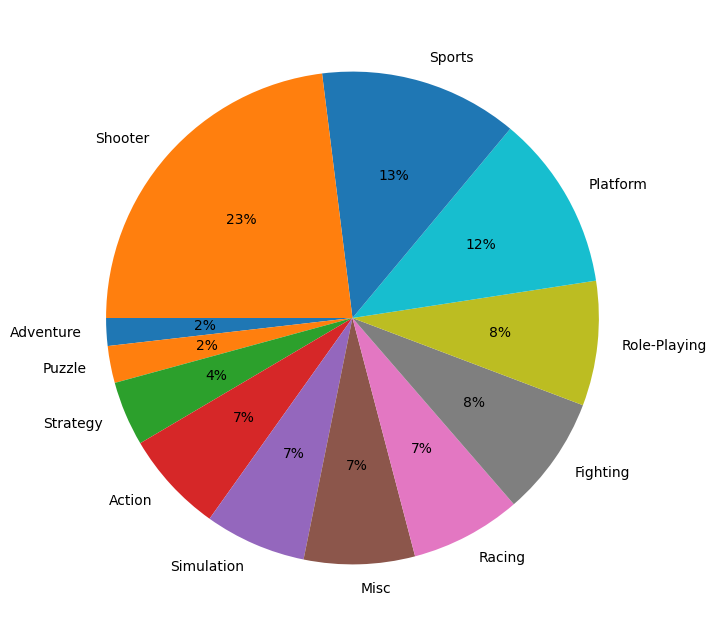

In [43]:
# Посмотрим на медианы продаж по жанрам за 2012-2016 гг.
display(df_5.pivot_table(index='genre', values='sum_sales',
                          aggfunc='median').sort_values('sum_sales', ascending=False).T)
# Построим круговую диаграмму распределения жанров по медианным продажам
df_5.pivot_table(index='genre', values='sum_sales', aggfunc='median').sort_values('sum_sales', ascending=True) \
.plot(kind='pie', y='sum_sales', autopct='%1.0f%%', ylabel='', legend=False, startangle=180, figsize=(8,8));

**Пятёрка лидеров среди жанров по количеству продаж vs среди выпускаемых игр:**

| |Лидеры по продажам|Лидеры среди выпускаемых игр|
|-|------------------|----------------------------|
|1|Shooter           |Action                      |
|2|Sports	         |Role-Playing                |
|3|Platform          |Adventure                   |
|4|Role-Playing      |Sports                      |
|5|Fighting          |Shooter                     |


<span style="font-size: 18px !important; color:blue">Пользователи (игроки) больше всего покупают <b>шутеры, спортивные симуляторы и платформеры.</b><br>
    Как видно - спрос и предложение не совсем совпадают. Либо разработчики не угадали в паре спрос-предложение, либо разработка игр одного жанра сложнее, чем другого, и предпочтения отдаётся в пользу простого. Ну как вариант - разработчики попросту не успевают за сменой предпочтений игроков. Пока разрабатываются игры одного жанра, в моду входит другой.<br>
Приключения, Стратегии и Пазлы покупаются хуже всего. Поэтому, чтобы создать крутой продукт в этом жанре, разработчикам придётся очень постараться. <br>
C другой стороны, эти два графика могут означать, что, из огромного числа выпускаемых игр покупается малая часть (например жанр Action). Но и малое количество выпускаемых игр определенного жанра не означает отсутствие дохода. Главным аспектом всё-таки является качество игры.<br>
Т.е., например, среди жанра Экшен много игр, но качественными является только малая часть, отсюда и малое число продаж.<br>
Лидером среди продаваемых жанров является Shooter, в то время, как самым выпускаемым является Action.</span>

# 4. Портрет пользователя каждого региона.

## 4.1 Самые популярные платформы

platform,X360,PS4,PS3,XOne,3DS
na_sales,140.05,108.74,103.38,93.12,55.31


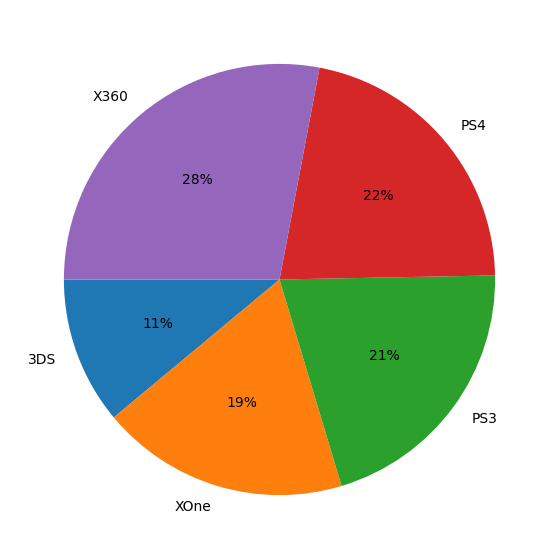

In [44]:
# ТОП-5 игровых платформ в Северной Америке
display(df_5.pivot_table(index='platform', values='na_sales',
                          aggfunc='sum').sort_values('na_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='platform', values='na_sales',
                  aggfunc='sum').sort_values('na_sales', \
ascending=True).tail(5).plot(kind='pie', y='na_sales', autopct='%1.0f%%',
                             legend=False, startangle=180, ylabel='', figsize=(7,7));

platform,PS4,PS3,X360,XOne,3DS
eu_sales,141.09,106.86,74.52,51.59,42.64


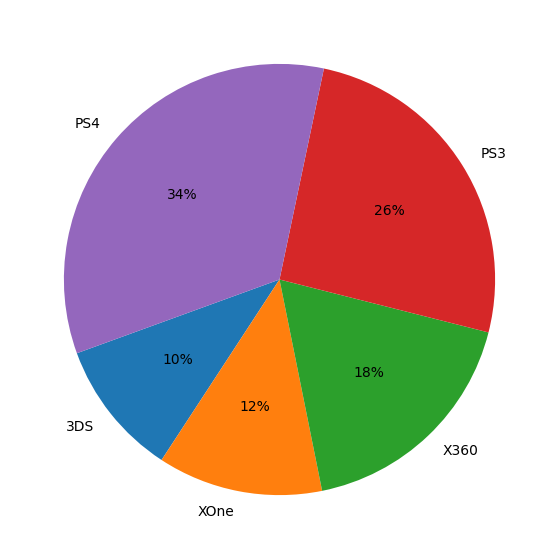

In [45]:
# ТОП-5 игровых платформ в Европе
display(df_5.pivot_table(index='platform', values='eu_sales',
                          aggfunc='sum').sort_values('eu_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='platform', values='eu_sales',
                  aggfunc='sum').sort_values('eu_sales', \
ascending=True).tail(5).plot(kind='pie', y='eu_sales', autopct='%1.0f%%',
                             legend=False, startangle=200, ylabel='', figsize=(7,7));

platform,3DS,PS3,PSV,PS4,WiiU
jp_sales,87.79,35.29,21.04,15.96,13.01


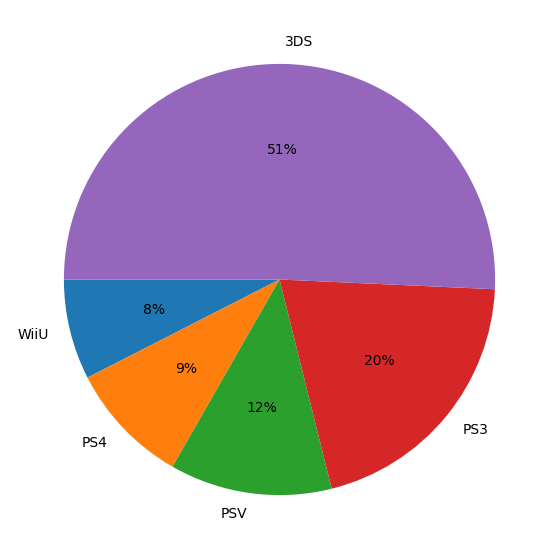

In [46]:
# ТОП-5 игровых платформ в Японии
display(df_5.pivot_table(index='platform', values='jp_sales',
                          aggfunc='sum').sort_values('jp_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='platform', values='jp_sales',
                  aggfunc='sum').sort_values('jp_sales', \
ascending=True).tail(5).plot(kind='pie', y='jp_sales', autopct='%1.0f%%',
                             legend=False, startangle=180, ylabel='', figsize=(7,7));

<span style="font-size: 18px !important; color:blue">Самые популярные игровые платформы по регионам:<br>
    Северная Америка - X360 (28%)<br>
    Япония - 3DS (51%)<br>
    Европа - PS4 (34%)<br>
   Поначалу я удивился таким тенденциям, но они вполне обоснованы. X360 - это "детище" Американской компании Microsoft. <br>
    3DS - Японской компании Nintendo. Логично предположить, что бОльшим спросом пользуются приставки  местного производителя. <br>
    Ну а Европейские игроки просто пробуют играть на всём, что поставляется на их рынок, отдавая при этом предпочтения в пользу PlayStation 3 и 4 поколений.<br>
Поражает любовь японцев к Nintendo 3DS. Доля продаж этой платформы в пятёрке лидеров заняла 51%!<br>
Возможно любовь к портативному варианту игровой приставки связана с тем, что, как принято считать, - в Японии бОльшую часть времени люди трудятся. И играют, судя по всему, в нечастые от работы перерывы, просто достав приставку из кармана.
</span>

## 4.2 Самые популярные жанры

genre,Action,Shooter,Sports,Role-Playing,Misc
na_sales,177.84,144.77,81.53,64.0,38.19


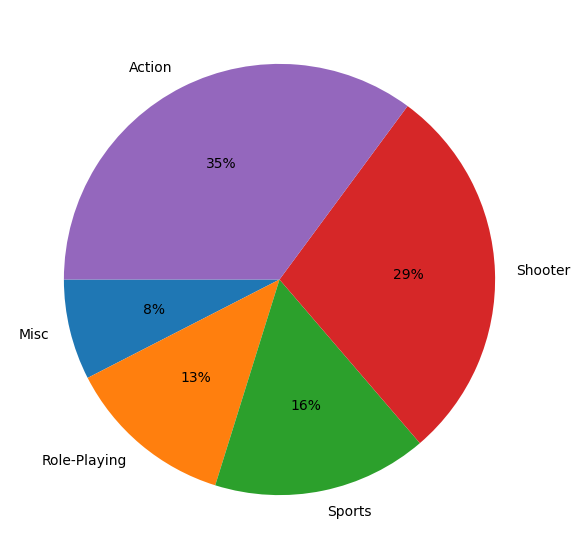

In [47]:
# ТОП-5 игровых жанров в Северной Америке
display(df_5.pivot_table(index='genre', values='na_sales',
                          aggfunc='sum').sort_values('na_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='genre', values='na_sales',
                  aggfunc='sum').sort_values('na_sales', \
ascending=True).tail(5).plot(kind='pie', y='na_sales', autopct='%1.0f%%',
                             legend=False, startangle=180, ylabel='', figsize=(7,7));

genre,Action,Shooter,Sports,Role-Playing,Racing
eu_sales,159.34,113.47,69.09,48.53,27.29


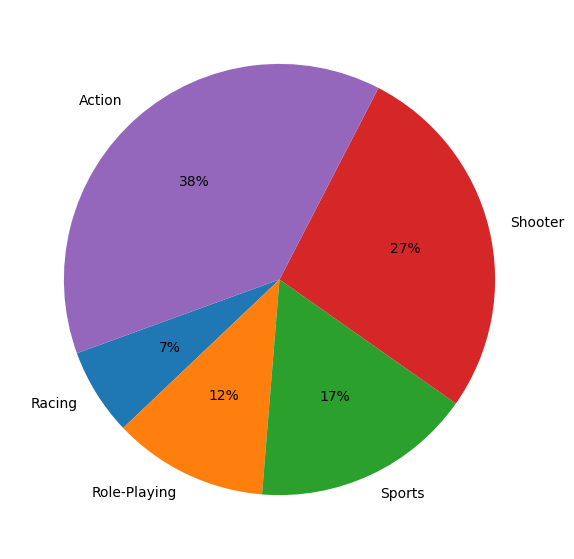

In [48]:
# ТОП-5 игровых жанров в Европе
display(df_5.pivot_table(index='genre', values='eu_sales',
                          aggfunc='sum').sort_values('eu_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='genre', values='eu_sales',
                  aggfunc='sum').sort_values('eu_sales', \
ascending=True).tail(5).plot(kind='pie', y='eu_sales', autopct='%1.0f%%',
                             legend=False, startangle=200, ylabel='', figsize=(7,7));

genre,Role-Playing,Action,Misc,Simulation,Fighting
jp_sales,65.44,52.8,12.86,10.41,9.44


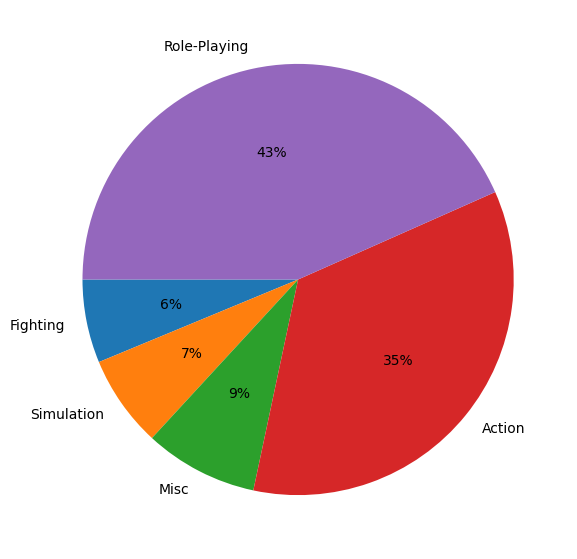

In [49]:
# ТОП-5 игровых жанров в Японии
display(df_5.pivot_table(index='genre', values='jp_sales',
                          aggfunc='sum').sort_values('jp_sales', ascending=False).head(5).T)
# Визуально доли продаж
df_5.pivot_table(index='genre', values='jp_sales',
                  aggfunc='sum').sort_values('jp_sales', \
ascending=True).tail(5).plot(kind='pie', y='jp_sales', autopct='%1.0f%%',
                             legend=False, startangle=180, ylabel='', figsize=(7,7));

<span style="font-size: 18px !important; color:blue">Самые популярные жанры по регионам:<br>
    Северная Америка - Action (35%)<br>
    Япония - Role-Playing (43%)	<br>
    Европа - Action (38%) <br>
   Японцы вновь выделяются, сместив самый популярный жанр в Америке и Европе на второе место, и отдав предпочтение жанру RPG. Думаю сказывается их любовь к Аниме и Покемонам - всё это реализовывается в жанре  Role-Playing.<br>
    <br>
<br>
</span>

## 4.3 Влияние рейтинга ESRB на продажи в отдельном регионе.

- **E** - («Everyone») — «Для всех» **(0+)**
- **E10+** - («Everyone 10 and older») — «Для всех от 10 лет и старше» **(10+)**
- **T** - («Teen») — «Подросткам» **(13+)**
- **M** - («Mature») — «Для взрослых» **(17+)**
- **AO** - («Adults Only 18+») — «Только для взрослых» **(18+)**

rating,M,E,no_rating,E10+,T
na_sales,231.57,114.37,103.31,75.7,66.02


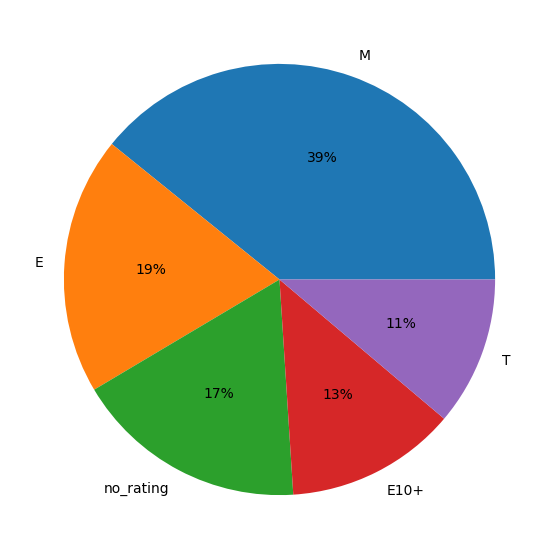

In [50]:
# Количество продаж в Северной Америке по рейтингу
display(df_5.pivot_table(index='rating', values='na_sales',
                          aggfunc='sum').sort_values('na_sales', ascending=False).T)
# Визуально в долях
df_5.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False) \
.plot(kind='pie', y='na_sales', autopct='%1.0f%%', legend=False, ylabel='', figsize=(7,7));

rating,M,E,no_rating,E10+,T
eu_sales,193.96,113.03,91.5,55.37,52.96


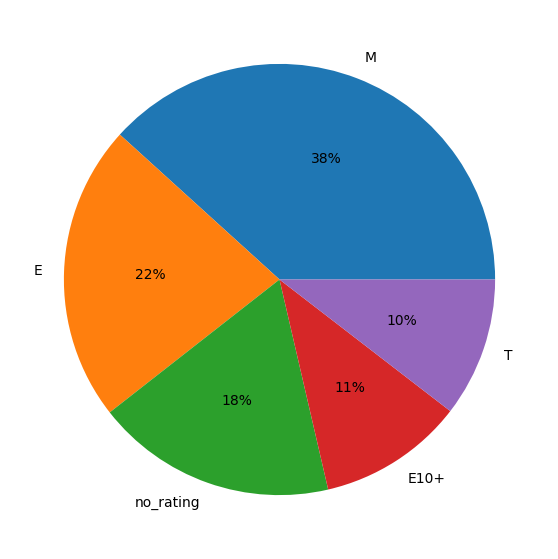

In [51]:
# Количество продаж в Европе по рейтингу
display(df_5.pivot_table(index='rating', values='eu_sales',
                          aggfunc='sum').sort_values('eu_sales', ascending=False).T)
# Визуально в долях
df_5.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False) \
.plot(kind='pie', y='eu_sales', autopct='%1.0f%%', legend=False, ylabel='', figsize=(7,7));

rating,no_rating,E,T,M,E10+
jp_sales,108.84,28.33,26.02,21.2,8.19


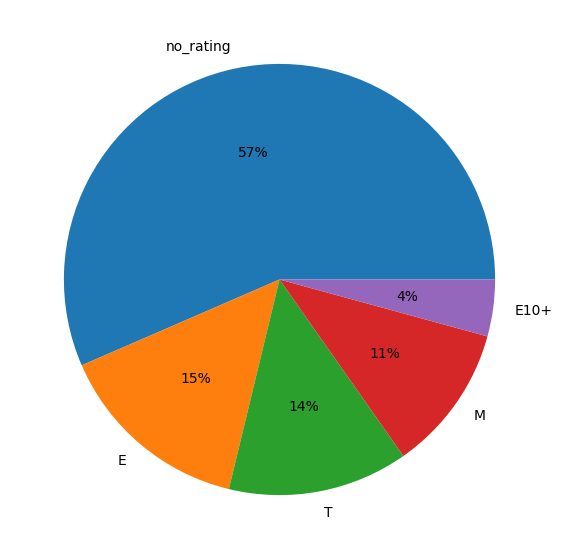

In [52]:
# Количество продаж в Японии по рейтингу
display(df_5.pivot_table(index='rating', values='jp_sales',
                          aggfunc='sum').sort_values('jp_sales', ascending=False).T)
# Визуально в долях
df_5.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False) \
.plot(kind='pie', y='jp_sales', autopct='%1.0f%%', legend=False, ylabel='', figsize=(7,7));

<span style="font-size: 18px !important; color:blue">На первом месте продажи игр с рейтингом:<br>
    Северная Америка - <b>M</b> (17+) (39%)<br>
    Европа - <b>M</b> (17+) (38%) <br>
    Япония - <b>E</b> (0+) (15%), <b>но</b> 57% игр - без оценки (рейтинга).	<br>
    В Северной Америке и Европе игры продаются примерно с одним распределением по рейтингу. Т.е. у 38-39% проданных игр - рейтинг "М" (17+). <br>
Выходит, что рынок игр в Северной Америке и Европе ориентирован в большей степени на взрослых игроков.
</span>

<span style="font-size: 18px !important; color:blue">
    Подводя итог, можно сказать, что в Северной Америке и Европе основная часть игроков предпочитает игры жанра Action с рейтингом "17+" для консолей PlayStation либо для X360.<br>
    Японские же игроки предпочитают поиграть на своих Nintendo 3DS в Role-playing игры. Оценить предпочтения Японцев в рейтинге игр считаю невозмоным, т.к. больше половины игр, проданным в Японии не присвоен рейтинг Entertainment Software Rating Board (ESRB) - компания которая находится в США и Канаде, и присваивает рейтинг на основе заявки от разработчика игр. Полагаю японским разработчикам не обязательно (либо не важно) получение этого рейтинга.<br>
    Но и в Северной Америке и в Европе 17-18% игр не имеют рейтинга от организации ESRB.
</span>

# 5. Проверка гипотез

## 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

<span style="font-size: 18px !important; color:blue"><br>
H₀ - средние пользовательские рейтинги платформ XBOX One и PC равны;<br><br>
H₁ - средние пользовательские рейтинки платформ XBOX One и PC неравны.<br><br>
Т.к. это гипотеза о равенстве средних двух генеральных совокупностей - буду использовать `st.ttest_ind`.<br>
Уровень статистической значимости alpha задам 0.01
</span>

In [53]:
# Для начала подготовим два среза по этим платформам. Брать будем по прежнему период 2012-2016 гг.
xbox = df_5.query('platform == "XOne" and user_score > 0')['user_score']
pc = df_5.query('platform == "PC" and user_score > 0')['user_score']

In [54]:
# Рейтинг и дисперсия
print('Средний пользовательский рейтинг платформы XBOX:', round(xbox.mean(),1)
      , ', дисперсия:', round(np.var(xbox, ddof=1),2))
print('Средний пользовательский рейтинг платформы   PC:', round(pc.mean(),1)
      , ', дисперсия:', round(np.var(pc, ddof=1),2))

Средний пользовательский рейтинг платформы XBOX: 6.5 , дисперсия: 1.91
Средний пользовательский рейтинг платформы   PC: 6.4 , дисперсия: 2.77


<span style="font-size: 18px !important; color:blue">
   Средние у выборок схожи. Дисперсии - отличаются.<br>
    Проверяем гипотезу.
</span>

In [55]:
alpha = 0.01
results = st.ttest_ind(xbox, pc, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


<span style="font-size: 18px !important; color:blue"><br>
НЕ ОТВЕРГАЕМ H₀, т.е. утверждение что <b>средние пользовательские рейтинги платформ XBOX One и PC одинаковые - ВЕРНО</b>
</span>

## 5.2 Средние пользовательские рейтинги жанров Action и Sports - разные.
<span style="font-size: 18px !important; color:blue"><br>
H₀ - Средние пользовательские рейтинги жанров Action и Sports равны;<br><br>
H₁ - Средние пользовательские рейтинги жанров Action и Sports не равны.<br><br>
Это также гипотеза о равенстве средних двух генеральных совокупностей - будем использовать `st.ttest_ind`.<br>
Уровень статистической значимости alpha задам 0.01<br>
</span>

In [56]:
# Для начала подготовим два среза по этим жанрам. Брать будем по прежнему период 2012-2016 гг.
action = df_5.query('genre == "Action" and user_score > 0')['user_score']
sport = df_5.query('genre == "Sports" and user_score > 0')['user_score']

In [57]:
# Рейтинг и дисперсия
print('Средний пользовательский рейтинг жанра Action:', round(action.mean(),1)
      , ', дисперсия:', round(np.var(action, ddof=1),2))
print('Средний пользовательский рейтинг жанра Sports:', round(sport.mean(),1)
      , ', дисперсия:', round(np.var(sport, ddof=1),2))

Средний пользовательский рейтинг жанра Action: 6.8 , дисперсия: 1.89
Средний пользовательский рейтинг жанра Sports: 5.5 , дисперсия: 3.02


<span style="font-size: 18px !important; color:blue">
   Средние у выборок и дисперсии - отличаются.<br>
    Проверяем гипотезу.
</span>

In [58]:
alpha = 0.01
results = st.ttest_ind(action, sport, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


<span style="font-size: 18px !important; color:blue"><br>
ОТВЕРГАЕМ H₀, т.е. утверждение что <b>средние пользовательские рейтинги жанров Action и Sports равны - НЕВЕРНО</b><br>
 А утверждение что <b>средние пользовательские рейтинги жанров Action и Sports разные - ВЕРНО.</b>
</span>

<span style="font-size: 18px !important; color:blue">
Обе гипотезы подтвердились.
</span>

# 6. Общий вывод

Данные для анализа содержат информацию о конкретных играх, платформах, годе релиза, количестве продаж, оценках пользователей и критиков.

В ходе предобработки данных были выявлены и обработаны пропуски.

Дубликатов выявлено не было.

Был проведён исследовательский анализ данных, в ходе которого было обозначено несколько моментов.

"Пик" продаж игр приходится на 2008-2009 гг. После этого начинается "спад". Я связываю это с появлением и развитием смартфонов, которые во многих направлениях "забирают хлеб" у остальных устройств.

Актуальным для исследования периодом принял 5 лет. Так, для прогноза на 2017 год я исследовал 2012-2016 гг.

Были выделены потенциально прибыльные платформы: PS4 и XOne. Также стоит обратить внимание на 3DS, PS3 и X360.

Наблюдалось, что игры с оценкой критиков 70+ покупают охотнее. Но напрямую количество продаж не зависит от оценки, которую дали критики или пользователи.

Больше всего пользователи (игроки) покупают шутеры, спортивные симуляторы и платформеры для PlayStation, XOne и Nintendo 3DS. Приключения, Пазлы и Стратегии покупаются хуже всего. Поэтому, чтобы создать продаваемый продукт в этом жанре, разработчикам придётся очень постараться.

На протяжении почти всего периода исследуемых данных проглядывается присутствие на рынке платформы PC. Это означает, что какими бы новшествами не удивляли игроков производители консолей, доля игроков на персональных компьютерах будет присутствовать всегда, хоть количество продаж игр для них и не будет ставить рекорды.